<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

# Analyzing Wet Snow Extent from SWS Time Series Based on Altitude

## Environment Setup
Before we begin, we need to prepare our environment by installing and importing the necessary Python libraries.

### Load Required Libraries

Most of the following modules are standard Python modules (tested with Python version 3.7.11, <a href="https://github.com/python/cpython/blob/3.7/LICENSE" target="_blank">License</a>):

*Included Python Modules:*  
- os : Miscellaneous operating system interfaces
- glob : Unix style pathname pattern expansion

*Included Python Packages:*
- <a href="https://gdal.org/api/python.html" target="_blank">gdal</a> (version 3.0.2)<br> 
<span style="margin-left:3%;">Tools for programming and manipulating the GDAL (Geospatial Data Abstraction Library). <b>License type:</b> MIT style <a href="https://github.com/OSGeo/gdal/blob/master/LICENSE.TXT" target="_blank">License</a></span><br>
- <a href="https://numpy.org/" target="_blank">numpy</a> (version 1.21.5)<br>
<span style="margin-left:3%;">NumPy is the fundamental package for array computing with Python. <b>License type:</b> BSD <a href="https://www.cgl.ucsf.edu/chimerax/docs/licenses/numpy-LICENSE.txt" target="_blank">License</a></span>
- <a href="https://matplotlib.org/" target="_blank">matplotlib</a> (version 3.5.1)<br>
<span style="margin-left:3%;">Python plotting package. <b>License type:</b> Python Software Foundation <a href="https://www.cgl.ucsf.edu/chimerax/docs/licenses/matplotlib-LICENSE_QT4_EDITOR.txt" target="_blank">License</a></span>

In [ ]:
import os
import glob

from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import glob
import tarfile

from hda import Client

## Functions

#### Function to Open and Read GeoTIFF Files, Assuming Downloaded Products Have Already Been Extracted

In [4]:
def readTif(file_tif):

    ds = gdal.Open(file_tif)
    
    # Projection
    proj = ds.GetProjection()

    # Dimensions
    width = ds.RasterXSize
    height = ds.RasterYSize

    # Number of bands
    count = ds.RasterCount

    # Metadata for the raster dataset
    meta = ds.GetMetadata()

    data = ds.ReadAsArray()

    ds = None
    
    return data, width, height, count, meta, proj

## Usage

#### Downloading SWS and DEM Data

To begin our analysis, we first need to download the necessary Snow Water Equivalent (SWS) and Digital Elevation Model (DEM) data. This can be accomplished using the HDA (Harmonized Data Access) client.  
The SWS data provides information on the extent of wet snow, while the DEM data offers detailed elevation information for the study area.  
By querying the HDA client with specific parameters such as dataset ID, observation period, and bounding box coordinates, we can retrieve and download the relevant datasets to our local directory for further processing and analysis.



In [ ]:
hda_client = Client()
hda_client.time_sleep = 10
hda_client.timeout = 10

download_dir = os.path.realpath("../../data/download/snow-and-ice/products")

query_sws = {
  "dataset_id": "EO:CRYO:DAT:HRSI:SWS",
  "observed_start": "2016-09-01T00:00:00.000Z",
  "observed_end": "2024-10-14T18:55:59.000Z",
  "bbox": [-26, 34, 46, 72]
}

query_dem = {
  "dataset_id": "EO:DEM:DAT:COP-DEM_GLO-30-DTED__2023_1",
  "bbox": [180, 90, -180, -90]
}

try:
    matches = hda_client.search(query_sws, limit=1)
    matches.download(download_dir)

    matches = hda_client.search(query_dem, limit=1)
    matches.download(download_dir)
except Exception as e:
    print(e)

#### Organizing Downloaded Files for Analysis

To facilitate the analysis, we extract the downloaded SWS and DEM files into dedicated directories. This organization ensures that all relevant data is readily accessible and systematically arranged, enhancing the efficiency of subsequent processing and analysis steps.

In [7]:
prod_dir = os.path.realpath("../../data/processing/snow-and-ice/products")

# Find all zip files
zip_files = glob.glob(os.path.join(download_dir, "SWS_*.zip"))

# Create SWS directory if it doesn't exist
sws_dir = os.path.join(prod_dir, "SWS")
if not os.path.exists(sws_dir):
    os.makedirs(sws_dir)

# Unzip each file 
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        for member in zip_ref.namelist():
            member_path = os.path.join(prod_dir, "SWS", os.path.basename(member))
            with zip_ref.open(member) as source, open(member_path, 'wb') as target:
                target.write(source.read())

In [8]:
# Find all tar files
tar_files = glob.glob(os.path.join(download_dir, "*.tar"))

# Create DEM directory if it doesn't exist
dem_dir = os.path.join(prod_dir, "DEM")
if not os.path.exists(dem_dir):
    os.makedirs(dem_dir)

# Extract each file
for tar_file in tar_files:
    with tarfile.open(tar_file, 'r') as tar_ref:
        for member in tar_ref.getmembers():
            if member.name.endswith(".dt2"):
                member_path = os.path.join(dem_dir, os.path.basename(member.name))
                with tar_ref.extractfile(member) as source, open(member_path, 'wb') as target:
                    target.write(source.read())

#### Converting DEM from 30m to 60m Resolution

In our analysis, we require a Digital Elevation Model (DEM) with a 60m resolution. However, a 60m DEM is not available for direct download from any source. The Copernicus DEM, which we are using, is available at a 30m resolution. To meet our requirements, we need to convert the 30m DEM to a 60m resolution.

In [ ]:
def convert_and_resample(input_dt2, output_tiff, resampled_tiff, x_res_deg, y_res_deg):

    dt2_dataset = gdal.Open(input_dt2)
    if dt2_dataset is None:
        raise ValueError(f"Could not open {input_dt2}")

    # Convert .dt2 to GeoTIFF
    gdal.Translate(output_tiff, dt2_dataset, format='GTiff')

    tiff_dataset = gdal.Open(output_tiff)
    if tiff_dataset is None:
        raise ValueError(f"Could not open {output_tiff}")

    # Resample the GeoTIFF to the desired resolution in meters 
    resampled_dataset = gdal.Warp(
        resampled_tiff,          
        tiff_dataset,    
        xRes=x_res_deg,          
        yRes=y_res_deg,          
        resampleAlg='bilinear'
    )

    if resampled_dataset is None:
        raise ValueError(f"Could not resample {output_tiff} to {resampled_tiff}")

    dt2_dataset = None
    tiff_dataset = None
    resampled_dataset = None

    print(f"Successfully converted {input_dt2} to {resampled_tiff} with {x_res_deg} x {y_res_deg} degrees resolution.")


dt2_files = glob.glob(os.path.join(dem_dir, "*.dt2"))

resampled_dir = os.path.join(dem_dir, "resampled")
if not os.path.exists(resampled_dir):
    os.makedirs(resampled_dir)


# 60 meters to degrees conversion 
x_res_deg = 60 / 111320  
y_res_deg = 60 / 111320 

# Convert and resample .dt2 files
for dt2_file in dt2_files:
    base_name = os.path.basename(dt2_file).replace('.dt2', '')
    output_tiff = os.path.join(resampled_dir, f"{base_name}.tif")
    resampled_tiff = os.path.join(resampled_dir, f"{base_name}_60m.tif")
    convert_and_resample(dt2_file, output_tiff, resampled_tiff, x_res_deg, y_res_deg)


In [10]:
files_wsm = glob.glob(os.path.join(prod_dir, "SWS", "SWS_*_WSM.tif"))
file_elev = glob.glob(os.path.join(prod_dir, "DEM/resampled", "*DEM_60m.tif"))

First, open and read all Wet Snow products for the mountains using the function defined below:

In [11]:
wsm_datas = []
for file_wsm in files_wsm:
    wsm_datas.append(readTif(file_wsm)[0])

Next, open and read the elevation data:

In [12]:
elev_data = readTif(file_elev[0])[0]

After loading the data, plot the elevation data and its associated colorbar for visualization.

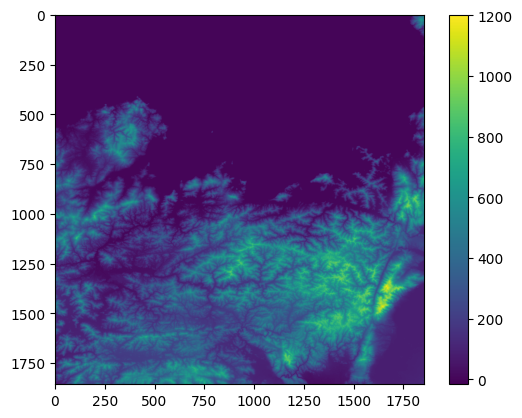

In [13]:
plt.imshow(elev_data);
plt.colorbar();

Then, plot the first SWS product of the time series, ensuring to add a standard colorbar (not the one attached to the product)

For details on the SWS product coding, please refer to the Product User Manual (https://land.copernicus.eu/user-corner/technical-library/hrsi-snow-pum):

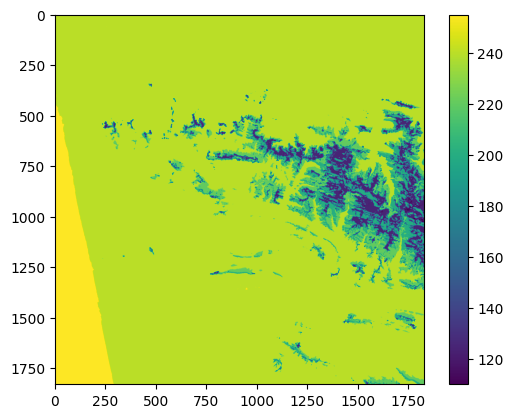

In [14]:
plt.imshow(wsm_datas[0]);
plt.colorbar();

Now, define the elevation intervals to be used for the analysis.
<table><tr><td>
Note: in this example, the elevation range covers 0 - 1600 m a.s.l., using an altitude interval of 200 m.
</td></tr></table>

In [53]:
dbin = 200
bins = np.arange(0, 1600, dbin)
elevs = bins[0:-1]+dbin/2

Extract the elevation information for wet snow pixels and add this data to a data frame  for all SWS products in the time series.

In [54]:
val_wet_snow = 110

hists = []
for wsm_data in wsm_datas:
    # Ensure sel matches the dimensions of elev_data
    sel = np.zeros_like(elev_data, dtype=bool)
    sel[:wsm_data.shape[0], :wsm_data.shape[1]] = (wsm_data == val_wet_snow)
    
    elev_sel = elev_data[sel]
    
    hists.append(np.histogram(elev_sel, bins=bins)[0])

Retrieve the dates from the SWS product file names to be used as legends in the next step:

In [55]:
labels_wsm = [os.path.splitext(os.path.basename(ele))[0] for ele in files_wsm]

Finally, prepare a plot showing the wet snow extent in relation to the altitude for the full SWS time series used as input.

Ensure that the legend (from the previous step) and axis labels are added for clarity.

In [ ]:
plt.figure(figsize=(12,8));
for hist, label_wsm in zip(hists, labels_wsm):
    plt.plot(hist, elevs, label=label_wsm[4:12]);
    
plt.legend();
plt.xlabel("Number of pixels");
plt.ylabel("Altitude [m a.s.l.]");


***
><span style = "font-family:Verdana; font-size:0.7em">Copyright © <font color='darkblue'>2022</font>, by ENVEO IT GmbH.</span>  
<span style = "font-family:Verdana; font-size:0.7em">Contributors: Lars Keuris,  Gabriele Schwaizer</span>  
<span style = "font-family:Verdana; font-size:0.7em">URL: www.enveo.at</span> 
***
<p style = "font-family:Verdana; font-size:0.7em; line-height:0.5">Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files, to use the Software without restriction.</p>  
<p style = "font-family:Verdana; font-size:0.7em; line-height:1.15; text-align:justify">THE SOFTWARE IS PROVIDED AS IS, WITHOUT WARRANTY OF ANYKIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. <b>IN NO EVENT SHALL THE COPYRIGHT HOLDER BE LIABLE FOR ANY CLAIM, DIRECT INDIRECT, SPECIAL, INCIDENTAL, OR CONSEQUENTIAL DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</b></p>

*** 